In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv
from functools import reduce
from matplotlib.ticker import FormatStrFormatter
import scipy.integrate as integrate

In [2]:
#PROPERTIES OF THE MATERIALS

freq = np.arange(1, 20000, 10)   #Frequency
omega = 2*np.pi*freq  #Angular velocity vector

#Porous material properties
c1 = 450
rho1 = 1700
z1 = rho1*c1
d = 50e-3   #Thickness of material [m]
Np = 0.71          #Prandlt number for air

phi = 0.5357;          #x(1)  Porosity
alpha_inf = 1.5098;   #%x(2)  Tortuosity
sigma = 10247;       #%x(3)  [Ns/m^4] flow resistivity
r_por = 0.22;         #%x(4) std dev of size pore
lamb = 1.28e-4;          #%x(4)  [um]  Viscous characteristic length    
lamb_prima = 2.56e-4;   #%x(5)  [um]   Thermal characteristic length  
#YMgruesa:    ϕ     α_∞     σ      Λ    Λ'
           #0.5357 1.5098  10247 1.28e-04 2.56e-04

#Properties for air
Pr = 0.71  #Prandtl number
rho0 = 1.204  #Density of air [kg/m^3]
c0 = 343  #Speed of sound[m/s]
z0 = rho0*c0  #[Rayl] Characteristic Impedance
gamma = 1.4   #Specific heat ratio
P0 =  101325 #Static pressure [Pa]
nu =  1.81e-5  #Viscosity of air [kg/m.s] 
l = 50e-3 #[m] air cavity thickness

#Rigid material properties
#Example
h = 12e-3 #[m] Thickness
rho = 440  #[kg/m^3] Density
Emod = 34.7e6  #[Pa] Young modulus
v = 0.3  #Poisson ratio
nu_mat = 0.05   #Loss factor [Pa/s]

#Boundary condition at the back-end of the material
termination = 'rigid' #['rigid' or 'anechoic']

In [3]:
#DEFINITIONS


#Dynamic bulk modulus and density for porous material (JCA model)

def dens_JCA(phi, alpha_inf, sigma, lamb, nu, rho0, omega):
    G2 = ((4*1j*(alpha_inf**2)*nu*rho0)*omega) / ((sigma**2) * (lamb**2)*(phi**2))
    d_JCA = (alpha_inf*rho0/phi) + (sigma / (1j*omega)) * np.sqrt(1 + G2)
    return d_JCA

def bulk_JCA(phi, lamb_prima, P0, Np, gamma, nu, rho0, omega):
    G1prima = 8*nu / (rho0*omega*Np*lamb_prima**2)
    G2prima = rho0*omega*Np*lamb_prima**2 / (16*nu)
    B_JCA = (gamma*P0/phi) / (gamma - (gamma - 1)*(1 + (G1prima/1j) * np.sqrt(1 + (1j*G2prima)))**(-1))
    return B_JCA


#-------------------------------------------------------------------------------
  
#Transfer matrix for porous material or air
def TM_poro(omega, D_poro, B_poro, l, theta = 0):
    """_summary_

    Args:
        omega (_type_): _Angular frequency_
        D_poro (_type_): _Effective dentisity_
        B_poro (_type_): _Effective Bulk Modulus_
        l (_type_): _Length of the material or layer [m]_
        theta (int, optional): _Angle of incidence of the acoustic wave_. Defaults to 0.

    Returns:
        _type_: _description_
    """
    Zc = np.sqrt(D_poro*B_poro)  #Characteristic impedance
    keff = omega*np.sqrt(D_poro/B_poro)
    
    TM_p = []
    theta = theta*(np.pi/180) #degree to radians
    if np.array(Zc).size > 1:
        for k, z in zip(keff, Zc):
            kz= np.sqrt(k**2 - k**2 * np.sin(theta)**2)
            Tm = np.matrix([[np.cos(kz*l), 1j*(z)*(k/kz)*np.sin(kz*l)],
                           [1j*(1/z)*(kz/k)*np.sin(kz*l), np.cos(kz*l)]])
            TM_p.append(Tm)
    elif np.array(keff).size > 1:
        for k in keff:
            kz = np.sqrt(k**2 - k**2 * np.sin(theta)**2)
            Tm = np.matrix([[np.cos(kz*l), 1j*(Zc)*(k/kz)*np.sin(kz*l)],
                        [1j*(1/Zc)*(kz/k)*np.sin(kz*l), np.cos(kz*l)]])
            TM_p.append(Tm)
    else:
        k = keff
        kz = np.sqrt(k**2 - k**2 * np.sin(theta)**2)
        Tm = np.matrix([[np.cos(kz*l), 1j*(Zc)*(k/kz)*np.sin(kz*l)],
                    [1j*(1/Zc)*(kz/k)*np.sin(kz*l), np.cos(kz*l)]])
        TM_p.append(Tm)
    return np.array(TM_p)

<h1 style='font-size:35px'><center>Porous Material</center></h1>

<img src="imag2.png" alt="Drawing" style="width: 40%; display: block; margin-left: auto; margin-right: auto;"/>

### Equivalent fluid: Considering JCA model
Dynamic effective density and bulk modulus of the porous material

$\rho_{p}(\omega)=\rho_{0}{\frac{\alpha_{\infty}}{\phi}}\biggl[1-i G_{1}(\omega)\sqrt{1+i G_{2}(\omega)}\,\biggr]\,$

$K_{p}(\omega)=K_{0}{\frac{\phi^{-1}}{\gamma-(\gamma-1)\left[1-i G_{1}^{\prime}(\omega)\sqrt{1+i G_{2}^{\prime}(\omega)}\right]^{-1}}}$

Where: 

$G_{1}(\omega)=\frac{\sigma\varphi}{\alpha_{\infty}\rho_{0}\omega},   $
$G_{2}(\omega)={\frac{4\alpha_{\infty}^{2}\rho_{0}\eta\omega}{\sigma^{2}\phi^{2}A^{2}}},   $
$G_{1}^{\prime}(\omega)={\frac{8\eta}{\rho_{0}\mathrm{Pr}A^{\prime2}\omega}},   $
$G_{2}^{\prime}(\omega)=\frac{\rho_{0}\mathrm{Pr}A^{\prime2}\omega}{16\eta}$

The wavenumber and acoustic impedance are:

$k_{p}={\frac{\omega}{c_{p}}}=\omega{\sqrt{\frac{\rho_{p}}{K_{p}}}},$

$Z_{p}={\sqrt{\rho_{p}K_{p}}}$

$G_{1}^{\prime}(\omega)={\frac{\phi\eta}{\rho_{0}\mathrm{Pr}k_{0}^{\prime}\omega}},$

- For anechoich termination the reflection R and transmission T coefficients are:

    $T_{a}=\frac{2\,e^{j k d}}{T_{11}+(\,T_{12}\,/\,\rho_{0}c\,)+\rho_{0}c\,T_{21}+T_{22}},$

    $R_{a}=\frac{T_{11}+(\;T_{12}/\rho_{0}c)-\rho_{0}c\;T_{21}-T_{22}}{T_{11}+(\;T_{12}/\rho_{0}c)+\rho_{0}c\;T_{21}+T_{22}}$

$\alpha=1-|R_a|^{2}-|T_a|^{2}\,$

- For a rigid back-end, the reflection coefficient can be expressed as (for symmetrical and recyprocal systems):

    $R={\frac{T_{11}-T_{21}Z_{0}}{T_{11}+T_{21}Z_{0}}}.$

and the absorption:

$\alpha=1-|R|^{2}\,$

In [4]:
#Porous material

#Effective properties from JCA model
D_poro = dens_JCA(phi, alpha_inf, sigma, lamb, nu, rho0, omega)
B_poro = bulk_JCA(phi, lamb_prima, P0, Np, gamma, nu, rho0, omega)

Zc_poro = np.sqrt(D_poro*B_poro)   #Characteristic impedance of the material
k_poro = omega*np.sqrt(D_poro/B_poro)

Z_poro = -1j*Zc_poro*(1/np.tan(k_poro*d))   #Surface impedance of the material
alpha_JCAL = 1 - np.abs((Z_poro - z0) / (Z_poro + z0))**2

TM_poromat = TM_poro(omega, D_poro, B_poro, d, 0)

alpha_poro = []
z_poroTM = []
T_poroTM = []
#Calculation absorption coeff from transfer matrix
for i in range(len(freq)):
    #TM_airporo = np.dot(TM_poromat[i], TM_air[i])
    TM_airporo = TM_poromat[i]
    Rpormat = (TM_airporo[0][0] - TM_airporo[1][0]*z0) / (TM_airporo[0][0] + TM_airporo[1][0]*z0)
    Ti = np.abs((2*np.exp(1j*k_poro[i]*d)) / (TM_airporo[0][0] + TM_airporo[0][1]/z0 + TM_airporo[1][0]/z0 + TM_airporo[1][1]))  #Transmission coefficient
    
    z_p = (TM_airporo[0][0] / TM_airporo[1][0])
    #Rpormat = (z_p - (z0))/(z_p + (z0))
    #Rpormat = (Z_poro[i] - (z0))/(Z_poro[i] + (z0))
    
    a_p = 1 - np.abs(Rpormat)**2
    alpha_poro.append(a_p)
    z_poroTM.append(z_p)
    T_poroTM.append(Ti)


In [5]:
Z_poro

array([588.95139183-6.02067792e+05j, 588.68984961-5.47379951e+04j,
       587.99435928-2.86786139e+04j, ..., 957.30745505+2.82896444e+01j,
       958.90920399+2.90578932e+01j, 960.52896876+2.97901650e+01j])

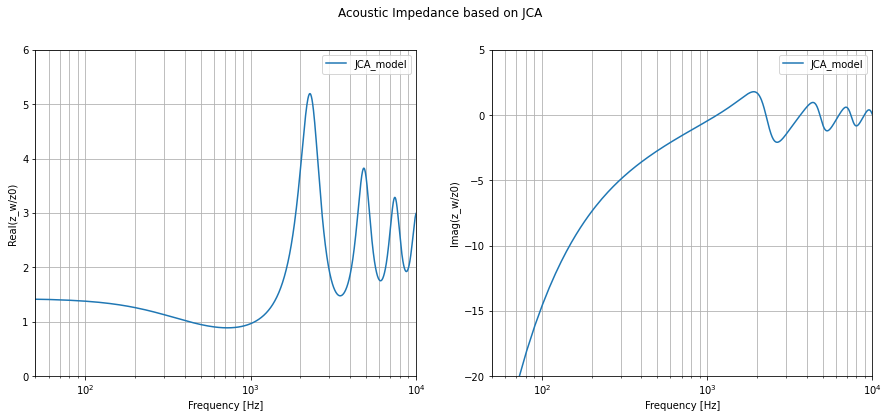

In [6]:
#Impedance plot of single homogenous porous material

f, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

axs[0].semilogx(freq, np.real(Z_poro/z0), label=f'JCA_model')
axs[0].legend()
axs[0].set_ylabel('Real(z_w/z0)')
axs[0].set_xlabel('Frequency [Hz]')
axs[0].set_xlim([50, 10000])
axs[0].set_ylim([0, 6])
axs[0].grid(which='both')
#ax2 = ax1.twinx()

axs[1].semilogx(freq, np.imag(Z_poro/z0), label=f'JCA_model')
axs[1].legend()
axs[1].set_ylabel('Imag(z_w/z0)')
axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_xlim([50, 10000])
axs[1].set_ylim([-20, 5])
axs[1].grid(which='both')
#f.tight_layout()
f.suptitle('Acoustic Impedance based on JCA')
plt.show() 

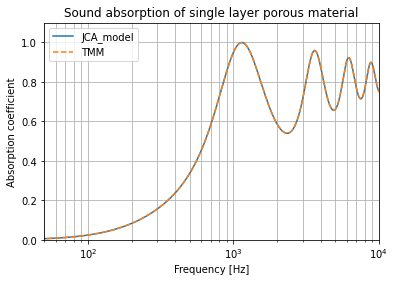

In [7]:
#Absorption of single material
plt.semilogx(freq, alpha_JCAL, label=f'JCA_model')
plt.semilogx(freq, alpha_poro, '--', label=f'TMM')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Absorption coefficient')
plt.title('Sound absorption of single layer porous material')
plt.ylim([0, 1.1])
plt.xlim([50, 10000])
plt.legend()
plt.grid(which= 'both')

### Multilayer porous material with Transfer Matrix approach 



In [8]:
#Multilayer porous material with Transfer Matrixapproach 

#YMgruesa:    ϕ     α_∞     σ      Λ    Λ'
           #0.5357 1.5098  10247 1.28e-04 2.56e-04 
#YM media:   ϕ     α_∞     σ      Λ    Λ'
          #0.4537 1.1028  12001 5.12e-05 1.89e-04
#YMcanarias(fina):   ϕ     α_∞     σ      Λ    Λ'
                  #0.5717 1.1136  21351 2.36e-05 2.27e-04

#[gruesa, fina, media]
N_layer = 3   #Number of layers
l_layer = [18e-3, 16e-3, 16e-3, 10e-3, 10e-3, 10e-3]   #Thickness of layers
phi_multi = [0.5357,  0.4537, 0.5717, 0.5357,  0.4537, 0.5717,];          #x(1)  Porosity
alpha_inf_multi = [1.5098, 1.1028, 1.1136, 1.5098, 1.1028, 1.1136];   #%x(2)  Tortuosity
sigma_multi = [4547, 12001, 35351, 7247, 12001, 35351];       #%x(3)  [Ns/m^4] flow resistivity
lamb_multi= [1.28e-4, 5.12e-05, 2.36e-05, 1.28e-4, 5.12e-05, 2.36e-05];          #%x(4)  [um]  Viscous characteristic length    
lamb_prima_multi = [2.56e-4, 1.89e-04, 2.27e-04, 2.56e-4, 1.89e-04, 2.27e-04];   #%x(5)  [um]   Thermal characteristic length  

TM_multi = []
Z_multi = []

for i in range(N_layer):
    D_poroi = dens_JCA(phi_multi[i], alpha_inf_multi[i], sigma_multi[i], lamb_multi[i], nu, rho0, omega)
    B_poroi = bulk_JCA(phi_multi[i], lamb_prima_multi[i], P0, Np, gamma, nu, rho0, omega)
    Zc_i = np.sqrt(D_poroi*B_poroi)  #Characteristic impedance
    k_i = omega*np.sqrt(D_poroi/B_poroi)
    Z_poroi = -1j*Zc_i*(1/np.tan(k_i*l_layer[i]))#Acoustic Surface Impedance of porous layer d
    Z_multi.append(Z_poroi)    
    #TM_i = TM_poro(k_i, l_layer[i], Zc_i)
    TM_i = TM_poro(omega, D_poroi, B_poroi, l_layer[i])
    TM_multi.append(TM_i)
    

alpha_multi = []
R_multi = []
z_TM = []

for i in range(len(freq)):
    if N_layer>1:
        TM_tot_por = TM_multi[0][i]
        for n in range(1, N_layer):   #Transfer matrix multiplication
            #TM_tot_por = reduce(np.dot, [TM_multi[n][i], TM_multi[n][i], TM_multi[n][i]])
            TM_tot_por = TM_tot_por @ TM_multi[n][i]
    else: 
        TM_tot_por = TM_multi[0][i]
    z_tm = (TM_multi[0][i][0][0] / TM_multi[0][i][1][0]) # Zs=(T11/T21) Surface impedance of material
    z_TM.append(z_tm/z0)
    #k_TM = (1/d)*
    if termination == 'rigid':
        #For rigid termination
        Ref = (TM_tot_por[0][0] - TM_tot_por[1][0]*z0) / (TM_tot_por[0][0] + TM_tot_por[1][0]*z0)    #Rigid termination at the end of the sample
        alpha_i = 1 - np.abs(Ref)**2
        R_multi.append(Ref)
        alpha_multi.append(alpha_i)
    elif termination == 'anechoic':
        #For anechoic termination
        Ref = (TM_tot_por[0][0] + (TM_tot_por[0][1]/z0) - TM_tot_por[1][0]*z0 -TM_tot_por[1][1]) / (TM_tot_por[0][0] + (TM_tot_por[0][1]/z0) + TM_tot_por[1][0]*z0 + TM_tot_por[1][1])    #Anechoich termination
        Tran = np.abs(1 / (TM_tot_por[0][0] + TM_tot_por[0][1]/z0 + TM_tot_por[1][0]/z0 + TM_tot_por[1][1]))
        alpha_i = 1 - np.abs(Ref)**2 - np.abs(Tran)**2
        R_multi.append(Ref)
        alpha_multi.append(alpha_i)
    

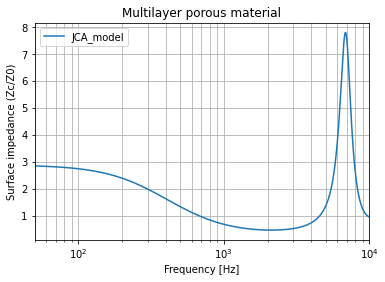

In [9]:
# Surface Impedance of multilayer material

#plt.plot(freq, Z_poro)
#plt.plot(freq, Z_multi[2])

plt.semilogx(freq, np.real(z_TM), label=f'JCA_model')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Surface impedance (Zc/Z0)')
#plt.ylim([0, 100])
plt.xlim([50, 10000])
plt.title('Multilayer porous material')
plt.legend()
plt.grid(which= 'both')

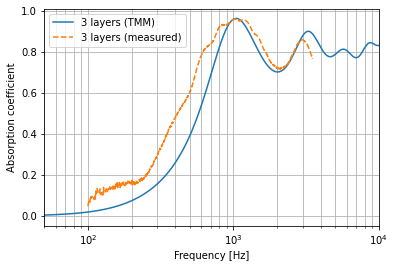

In [10]:
#Plot absorption curves

alpha_multi_meas = []
freq_meas = []
#Load measured data
with open('absCoef_3dens.txt') as file:   #'absCoef_3dens.txt' 'absCoef_gruesa.txt'
    f = file.readlines()
    for line in f:
        lin = line.strip().split('\t')
        alpha_multi_meas.append(float(lin[1]))
        freq_meas.append(float(lin[0]))
        

plt.semilogx(freq, alpha_multi, label=f'3 layers (TMM)')
plt.semilogx(freq_meas, alpha_multi_meas,'--', label=f'3 layers (measured)')
#plt.semilogx(freq, R_multi,'--', label=f'R')
#plt.semilogx(freq, alpha_poro, '-.', label=f'Single layer (TMM)')

plt.xlabel('Frequency [Hz]')
plt.ylabel('Absorption coefficient')
#plt.ylim([0, 1.1])
plt.xlim([50, 10000])
plt.legend()
plt.grid(which= 'both')

### Oblique incidence

- The following part tends to estimate the absoprtion coefficient for oblique incidence either for single homogenous porous materials as well as multilayer configurations. The calculus are based on the JCA model, the TMM and/or measurements in impedance tube.
- The absorption coefficient is estimated for diffuse field based on the Paris' formula (from absorption curve at normal incidence, measured or from analytical models).
- Integration over angle of incidence 0° - 80° 

In [11]:

alpha_test = []
def integrand(theta, f):
    omg = f*2*np.pi
   
    theta_deg = theta * (180/np.pi)
    #print(f, theta_deg)
    D_poroi = dens_JCA(phi, alpha_inf, sigma, lamb, nu, rho0, omg)
    B_poroi = bulk_JCA(phi, lamb_prima, P0, Np, gamma, nu, rho0, omg)
    TM_i = TM_poro(omg, D_poroi, B_poroi, d, theta_deg)
    TM_i = TM_i[0]
    Ref = (TM_i[0][0]*np.cos(theta) - TM_i[1][0]*z0) / (TM_i[0][0]*np.cos(theta) + TM_i[1][0]*z0)
    #Ref = (TM_i[0][0] - TM_i[1][0]*z0) / (TM_i[0][0] + TM_i[1][0]*z0)
    alpha_i = 1 - np.abs(Ref)**2
    alpha_test.append(alpha_i)
    #alpha_f = (alpha_i*np.sin(2*theta))
    #alpha_f = (alpha_i*np.cos(theta)*np.sin(theta)) / (np.sin(theta)*np.cos(theta))
    alpha_f = 2*(alpha_i*np.cos(theta)*np.sin(theta)) 
    
    #alpha_f = (alpha_i*np.sin(theta)) #From London
    return alpha_f

def integrand2(theta, alph):
    alpha_f = (alph*np.sin(2*theta))
    #alpha_f = (alph*np.cos(theta)*np.sin(theta)) / (np.sin(theta)*np.cos(theta))
    return alpha_f
    
abs_diff = []
for i, f in enumerate(freq):
    #abs_i, err = integrate.quad(integrand, 0, 90*(np.pi/180), args=(f, ))
    alph = alpha_poro[i]
    abs_i, err = integrate.quad(integrand, 0, 90*(np.pi/180), args=(f, ))
    abs_diff.append(abs_i)

    


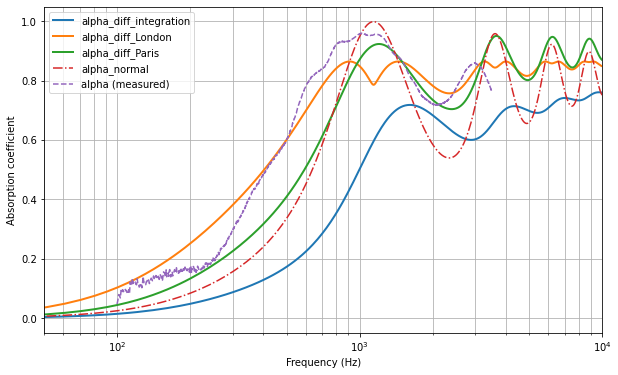

In [12]:
def abs_diff_london(alpha_normal):
    alpha_london = []
    for alpha in alpha_normal:
        ze_tube = (1 + (1 - alpha)**(0.5)) / (1 - (1 - alpha)**(0.5))
        #alpha_l = (8/(ze_tube**2)) * (1 + ze_tube - (1/(1+ze_tube)) - 2*np.log(1 + ze_tube))
        alpha_l = (4/(ze_tube)) * (np.log(1 + ze_tube) - (ze_tube/(1+ze_tube)))
        alpha_london.append(alpha_l)
    return alpha_london

def abs_diff_paris(z_normal):
    alpha_paris = []
    r = np.real(z_normal/z0)
    x = np.imag(z_normal/z0)
    for ri, xi in zip(r, x):
        #print(ri,xi)
        alpha_i = ((8*ri)/(xi**2 + ri**2)) * (1 + ((ri**2-xi**2)/(xi*(xi**2+ri**2)))*np.arctan(xi/(1+ri)) - (ri/(xi**2+ri**2))*(np.log((1+ri)**2 + xi**2)))
        alpha_paris.append(alpha_i)
    return alpha_paris


alpha_paris =  abs_diff_paris(Z_poro)       
alpha_london = abs_diff_london(alpha_poro)

linewidth=2
f, (axs) = plt.subplots(1, 1, figsize=(10, 6), sharey=True)
axs.semilogx(freq, abs_diff,'-', marker='', linewidth=linewidth, label=f'alpha_diff_integration')
#axs.semilogx(freq, alpha_test,'-', marker='', linewidth=linewidth, label=f'alpha normal test')
axs.semilogx(freq, alpha_london,'-', marker='', linewidth=linewidth, label=f'alpha_diff_London')
axs.semilogx(freq, alpha_paris,'-', marker='', linewidth=linewidth, label=f'alpha_diff_Paris')
axs.semilogx(freq, alpha_poro, '-.', label=f'alpha_normal')
axs.semilogx(freq_meas, alpha_multi_meas,'--', label=f'alpha (measured)')
axs.legend()
axs.set_ylabel('Absorption coefficient')
axs.set_xlabel('Frequency (Hz)')
axs.set_xlim([50, 10000])
axs.legend()
axs.grid(which= 'both')